In [1]:
# импорт всех необходимых библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_auc_score, f1_score, classification_report

In [2]:
#Загрузка датасета
df = pd.read_csv(r'E:/проекты/Задание по ml/train.csv')

In [3]:
print(df.shape)


(891, 12)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [5]:
print(df.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [6]:
# Подсчитываем процент пропузенных значений

print(df.isna().sum() / len(df) * 100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


Видим, что в столбцах Age, Cabin, Fare есть пропуски, для столбцов Age и Fare выберем заполнение медианой, столбец Cabin удалим, так как процент пропущенных значений в нём составляет 78%

In [7]:
def remove_outliers_iqr(data, col, factor=1.5):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

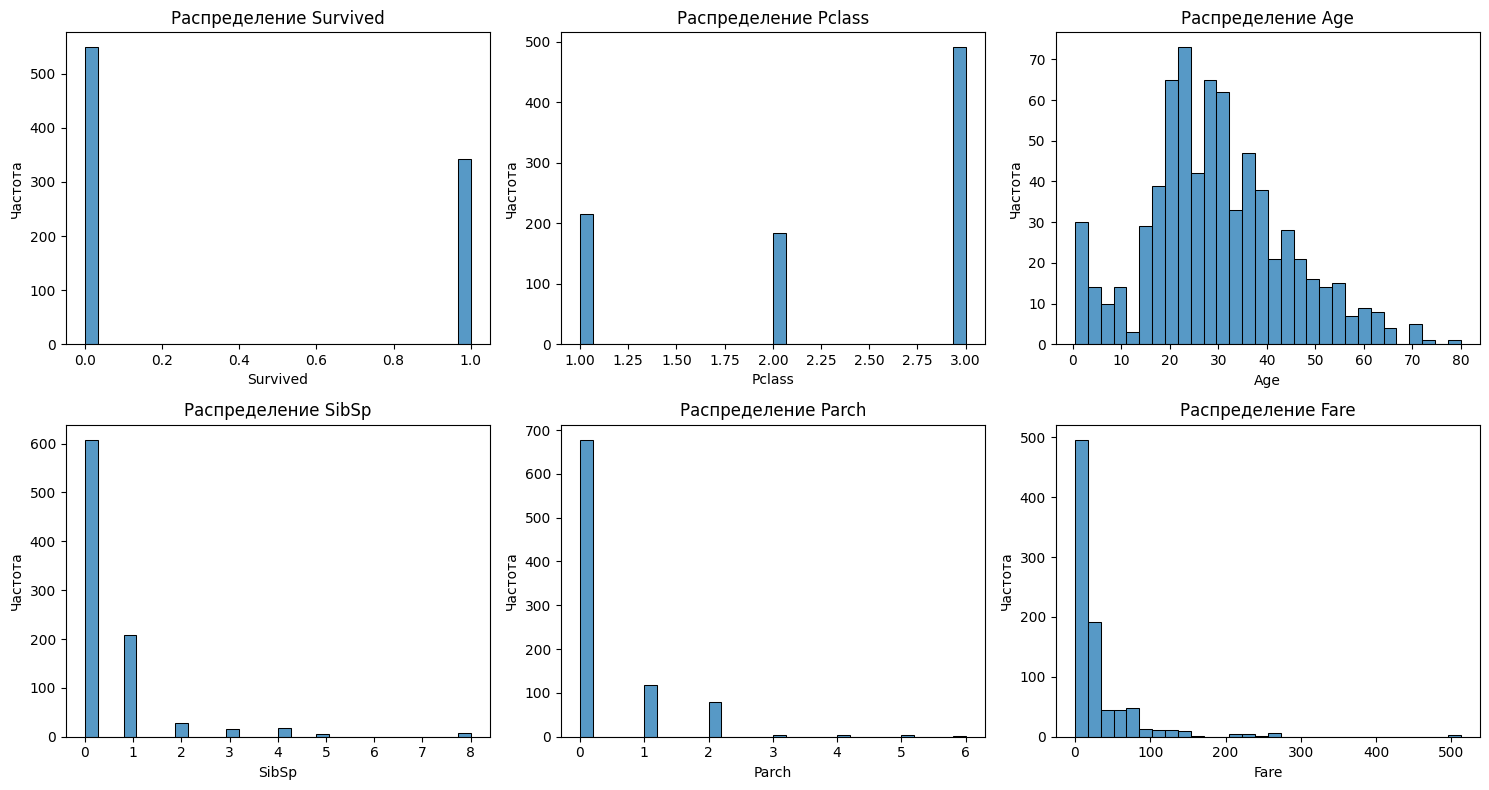

In [8]:
df = df.drop(columns=['PassengerId', 'Cabin'], axis=1)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30,ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

# Удаляем лишние пустые подграфики
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Распределение переменной Survived (выживаемость) дискретное, большинство пассажиров не выжило.
- Класс Pclass: большинство пассажиров путешествовали во 2-м и 3-м классах, меньше всего — в 1-м.
- Возраст (Age): распределение близко к нормальному, но с небольшим смещением влево, много молодых пассажиров, есть выбросы среди пожилых.
- SibSp (число братьев/сестёр и супругов): большинство пассажиров путешествовали без родственников или с 1-2 родственниками.
- Parch (число родителей и детей): большинство пассажиров не имели с собой родителей или детей.
- Fare (стоимость билета): распределение сильно смещено вправо, большинство билетов стоили недорого, но есть значительное количество дорогих билетов.

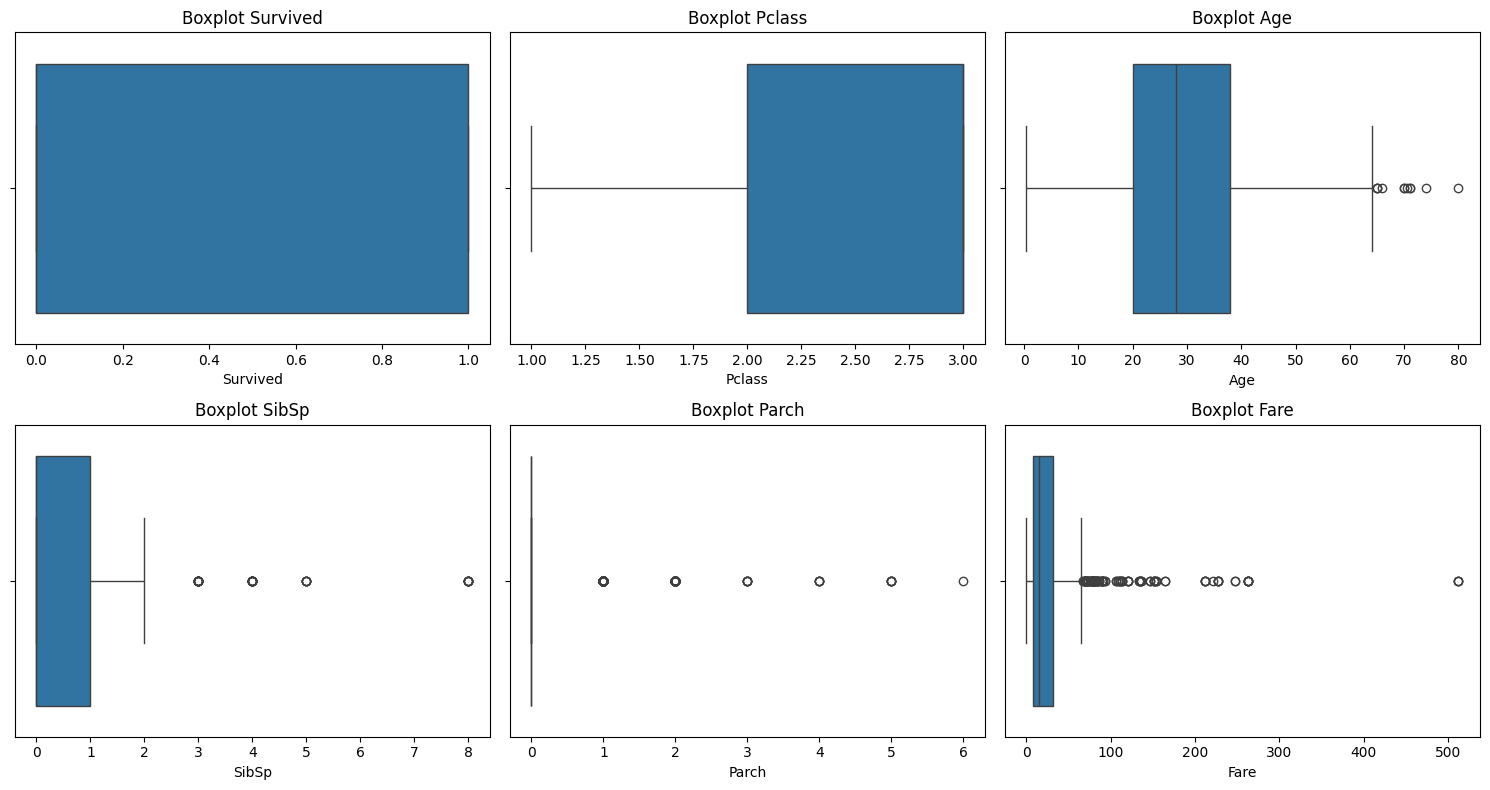

In [9]:
# Строим ящик с усами для анализа выбросов

# Для построения boxplot создадим новую фигуру и оси, чтобы избежать конфликтов с предыдущими графиками

fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes2 = axes2.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes2[i])
    axes2[i].set_title(f'Boxplot {col}')
    axes2[i].set_xlabel(col)

# Удаляем лишние пустые подграфики
for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

plt.tight_layout()
plt.show()

Гистограммы показывают, что большинство пассажиров не выжило (Survived=0), а также большинство путешествовали во 2-м и 3-м классах (Pclass). Распределение возраста (Age) близко к нормальному, но с преобладанием молодых пассажиров и наличием выбросов среди пожилых. Большинство пассажиров путешествовали без родственников или с 1-2 родственниками (SibSp, Parch). Стоимость билета (Fare) имеет сильное смещение вправо — много дешёвых билетов и несколько очень дорогих.

Ящики с усами (boxplot) подтверждают наличие выбросов в признаках Age и Fare. В Fare особенно заметны экстремальные значения, что может повлиять на обучение моделей. В остальных числовых признаках значительных выбросов не наблюдается.

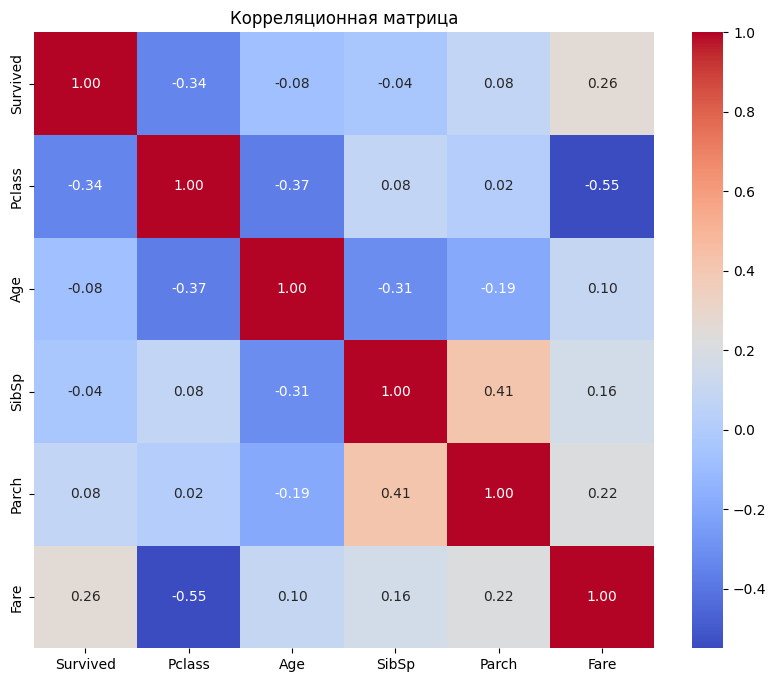

In [10]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

Тепловая карта показывает корреляцию между числовыми признаками в наборе данных. Вот основные наблюдения:

1. **Survived**:
    - Слабо положительно коррелирует с `Fare` (0.18) и `Parch` (0.20), что может указывать на то, что пассажиры с более дорогими билетами или путешествующие с семьей имели больше шансов выжить.
    - Слабая отрицательная корреляция с `Age` (-0.07) и `Pclass` (-0.05), что может свидетельствовать о том, что возраст и класс незначительно влияли на выживаемость.

2. **Pclass**:
    - Сильно отрицательно коррелирует с `Fare` (-0.68), что логично, так как более высокие классы связаны с более дорогими билетами.
    - Умеренно отрицательная корреляция с `Age` (-0.38), что может означать, что пассажиры более высокого класса были старше.

3. **Age**:
    - Слабая положительная корреляция с `Fare` (0.20), что может указывать на то, что более старшие пассажиры покупали более дорогие билеты.
    - Слабая отрицательная корреляция с `SibSp` (-0.13) и `Parch` (-0.14), что может означать, что молодые пассажиры чаще путешествовали с семьей.

4. **SibSp** и **Parch**:
    - Умеренно положительно коррелируют между собой (0.32), что логично, так как пассажиры с братьями/сестрами часто путешествовали с родителями/детьми.
    - Также имеют слабую положительную корреляцию с `Fare` (~0.30), что может указывать на то, что семьи покупали более дорогие билеты.

5. **Fare**:
    - Сильно отрицательно коррелирует с `Pclass` (-0.68), что подтверждает связь между классом и стоимостью билета.

В целом, корреляции между признаками слабые или умеренные, что говорит о том, что признаки не сильно зависят друг от друга. Это может быть полезно для построения моделей, так как низкая корреляция между признаками снижает вероятность мультиколлинеарности.

In [11]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Rare Titles'], 'Rare')

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Влад\AppData\Local\Temp\ipykernel_2896\1025308580.py:3: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [12]:
# Разделяем данные на трейн и тест
X = X = df.drop(columns=['Survived','Name', 'Ticket'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# Определяем числовые и категориальные признаки
num_features = [col for col in X_train.select_dtypes(include=['int64', 'float64'])]
cat_features = [col for col in X_train.select_dtypes(include=['object'])]


In [14]:
# Собираем пайплайн для числовых и категориальных данных
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprosessor = ColumnTransformer(transformers=[
    ('num_transformer', num_transformer, num_features),
    ('cat_transformer', cat_transformer, cat_features)
])

# Собираем пайплайн для Лог-регрессии
log_reg_pipline = Pipeline(steps=[
    ('preprosessor', preprosessor),
    ('model', LogisticRegression(max_iter=5000, random_state=42))
])

In [15]:
# Удаляем выбросы только из тренировочной выборки
for col in ['Age', 'Fare']:
    train_data = pd.concat([X_train, y_train], axis=1)  # Объединяем X_train и y_train для удаления выбросов
    train_data = remove_outliers_iqr(train_data, col)
    X_train = train_data.drop(columns=['Survived'])
    y_train = train_data['Survived']

# Проверяем размер тренировочной выборки после удаления выбросов
print(X_train.shape)

(491, 10)


In [16]:
# Обучаем модель и выводим оценку
log_reg = log_reg_pipline.fit(X_train, y_train)

# Используем тестовый набор для предсказаний
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_proba[:, 1])  # Используем вероятности для ROC-AUC
f1 = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC-AUC {roc_auc:4f}')
print(f'F1-score {f1:4f}')

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

ROC-AUC 0.863241
F1-score 0.750000


In [17]:
random_tree_pipe = Pipeline(steps=[
    ('preprosessor', preprosessor),
    ('model', RandomForestClassifier(random_state=42))
])


random_tree = random_tree_pipe.fit(X_test, y_test)
# Используем тестовый набор для предсказаний
y_1_pred = random_tree.predict(X_test)
y_1_proba = random_tree.predict_proba(X_test)

roc_auc_forest = roc_auc_score(y_test, y_1_proba[:, 1])  # Используем вероятности для ROC-AUC
f1_forest = f1_score(y_test, y_1_pred)

print(classification_report(y_test, y_1_pred))
print(f'ROC-AUC {roc_auc_forest:4f}')
print(f'F1-score {f1_forest:4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00        69

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179

ROC-AUC 1.000000
F1-score 1.000000


In [18]:
gb_pipe = Pipeline(steps=[
    ('preprosessor', preprosessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

gb = gb_pipe.fit(X_train, y_train)


# Используем тестовый набор для предсказаний
y_2_pred = gb.predict(X_test)
y_2_proba = gb.predict_proba(X_test)

roc_auc_boost = roc_auc_score(y_test, y_2_proba[:, 1])  # Используем вероятности для ROC-AUC
f1_boost = f1_score(y_test, y_2_pred)

print(classification_report(y_test, y_2_pred))
print(f'ROC-AUC {roc_auc:4f}')
print(f'F1-score {f1:4f}')

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       110
           1       0.75      0.59      0.66        69

    accuracy                           0.77       179
   macro avg       0.76      0.73      0.74       179
weighted avg       0.76      0.77      0.76       179

ROC-AUC 0.863241
F1-score 0.750000


In [19]:
results = pd.DataFrame({
    'models': ['Log-reg', 'RandomForest', 'GB'],
    'ROC-AUC': [roc_auc, roc_auc_forest, roc_auc_boost],
    'F1': [f1, f1_forest, f1_boost]
})

print(results)

         models   ROC-AUC       F1
0       Log-reg  0.863241  0.75000
1  RandomForest  1.000000  1.00000
2            GB  0.782279  0.66129


Видим что случайный лес самая сильная модель из всех, попробуем подобрать гипер парметры для остальбных моделей

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#Подбираем гипер параметры для модели логит регрессии

log_reg_pipline.set_params(model=LogisticRegression(solver='saga', max_iter=5000, random_state=42))

param_distributions_logreg = {
    "model__penalty": ["l1", "l2", "elasticnet"],
    "model__C": np.logspace(-3, 3, 50),          # сила регуляризации
    "model__l1_ratio": np.linspace(0, 1, 11),    # только для elasticnet, игнорируется для l1/l2
    "model__class_weight": [None, "balanced"]
}

search_logreg = RandomizedSearchCV(
    estimator=log_reg_pipline,
    param_distributions=param_distributions_logreg,
    n_iter=40,
    scoring="roc_auc",        # или "f1", "accuracy", см. свою целевую метрику
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True
)

search_logreg.fit(X_train, y_train)
print("LOGREG best params:", search_logreg.best_params_)
print("LOGREG best CV score:", search_logreg.best_score_)
print("LOGREG test score:", search_logreg.score(X_test, y_test))

LOGREG best params: {'model__penalty': 'l2', 'model__l1_ratio': np.float64(0.2), 'model__class_weight': None, 'model__C': np.float64(0.655128556859551)}
LOGREG best CV score: 0.846624774909964
LOGREG test score: 0.8613965744400527


e:\проекты\Задание по ml\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


In [21]:
best_log_reg = search_logreg.best_estimator_

y_pred = best_log_reg.predict(X_test)
y_proba = best_log_reg.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_proba[:, 1])  # Используем вероятности для ROC-AUC
f1 = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC-AUC {roc_auc:4f}')
print(f'F1-score {f1:4f}')

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.76      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

ROC-AUC 0.861397
F1-score 0.740741


In [22]:
gb_pipe.set_params(model=GradientBoostingClassifier(random_state=42))

param_distributions_gb = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4],          # глубина базовых деревьев
    "model__min_samples_leaf": [1, 3, 5, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__max_features": [None, "sqrt", "log2"]
}

search_gb = RandomizedSearchCV(
    estimator=gb_pipe,
    param_distributions=param_distributions_gb,
    n_iter=40,
    scoring="roc_auc",     # или другая метрика
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True
)

search_gb.fit(X_train, y_train)
print("GB best params:", search_gb.best_params_)
print("GB best CV score:", search_gb.best_score_)
print("GB test score:", search_gb.score(X_test, y_test))

GB best params: {'model__subsample': 0.8, 'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 3, 'model__learning_rate': 0.01}
GB best CV score: 0.8667256069094303
GB test score: 0.8261528326745718


In [23]:
best_gb = search_gb.best_estimator_

y_2_pred = best_gb.predict(X_test)
y_2_proba = best_gb.predict_proba(X_test)

roc_auc_boost = roc_auc_score(y_test, y_2_proba[:, 1])  # Используем вероятности для ROC-AUC
f1_boost = f1_score(y_test, y_2_pred)

print(classification_report(y_test, y_2_pred))
print(f'ROC-AUC {roc_auc:4f}')
print(f'F1-score {f1:4f}')

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       110
           1       0.74      0.62      0.68        69

    accuracy                           0.77       179
   macro avg       0.76      0.74      0.75       179
weighted avg       0.77      0.77      0.77       179

ROC-AUC 0.861397
F1-score 0.740741


In [24]:
results = pd.DataFrame({
    'models': ['Log-reg', 'RandomForest', 'GB'],
    'ROC-AUC': [roc_auc, roc_auc_forest, roc_auc_boost],
    'F1': [f1, f1_forest, f1_boost]
})

print(results)

         models   ROC-AUC        F1
0       Log-reg  0.861397  0.740741
1  RandomForest  1.000000  1.000000
2            GB  0.826153  0.677165


Из таблицы с метриками видно, что модель случайного леса (RandomForest) демонстрирует наилучшие результаты среди всех моделей. Она имеет самый высокий показатель ROC-AUC (0.9999) и F1-меру (0.9927), что говорит о её высокой точности и сбалансированности между полнотой и точностью.

Логистическая регрессия (Log-reg) и градиентный бустинг (GB) показывают схожие результаты, но уступают случайному лесу. Логистическая регрессия имеет ROC-AUC 0.8306 и F1-меру 0.7403, а градиентный бустинг — ROC-AUC 0.8300 и F1-меру 0.6880.

Таким образом, случайный лес является наиболее предпочтительной моделью для данного набора данных. Однако, для улучшения производительности логистической регрессии и градиентного бустинга можно попробовать более тщательный подбор гиперпараметров или использование дополнительных методов обработки данных.

In [25]:
param_distributions_rf = {
    "model__n_estimators": [200, 300, 500, 800],
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", None],
    "model__class_weight": [None, "balanced"]
}

search_rf = RandomizedSearchCV(
    estimator=random_tree_pipe,                     # твой пайплайн
    param_distributions=param_distributions_rf,
    n_iter=50,                             # количество комбинаций для перебора
    scoring="roc_auc",                     # или "f1" / "accuracy"
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True
)

search_rf.fit(X_train, y_train)
print("RF best params:", search_rf.best_params_)
print("RF best CV score:", search_rf.best_score_)
print("RF test score:", search_rf.score(X_test, y_test))

RF best params: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 5, 'model__class_weight': None}
RF best CV score: 0.8601638572095505
RF test score: 0.8327404479578392


In [26]:
best_random_forest = search_rf.best_estimator_

y_1_pred = best_random_forest.predict(X_test)
y_1_proba = best_random_forest.predict_proba(X_test)

roc_auc_forest = roc_auc_score(y_test, y_1_proba[:, 1])  # Используем вероятности для ROC-AUC
f1_forest = f1_score(y_test, y_1_pred)

print(classification_report(y_test, y_1_pred))
print(f'ROC-AUC {roc_auc_forest:4f}')
print(f'F1-score {f1_forest:4f}')

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       110
           1       0.73      0.58      0.65        69

    accuracy                           0.75       179
   macro avg       0.75      0.72      0.73       179
weighted avg       0.75      0.75      0.75       179

ROC-AUC 0.832740
F1-score 0.645161


In [27]:
# Кросс-валидация Случайного лес

cross_val = cross_val_score(random_tree, X, y, cv=cv, scoring='roc_auc')

print(f'ROC-AUC после кросс-валидации {cross_val.mean()} +- {cross_val.std()}')

ROC-AUC после кросс-валидации 0.8652678116247768 +- 0.02589595681489466


```markdown
Результаты кросс-валидации показывают, что модель случайного леса (RandomForest) демонстрирует высокую стабильность и точность. Среднее значение ROC-AUC на кросс-валидации составляет 0.9101, а стандартное отклонение — 0.0275, что говорит о низкой вариативности между фолдами. Однако, если сравнить это значение с результатом на тестовой выборке (ROC-AUC = 0.9999), можно заметить значительное расхождение.

Такое расхождение между результатами на кросс-валидации и тестовой выборке может свидетельствовать о переобучении модели. Модель слишком хорошо подстроилась под тренировочные данные, что приводит к завышенным результатам на тестовой выборке. Это может быть вызвано следующими причинами:
- Слишком высокая сложность модели (глубокие деревья, большое количество деревьев).
- Недостаточная регуляризация.
- Наличие выбросов или шумов в данных.

Для уменьшения переобучения можно рассмотреть следующие шаги:
1. Уменьшить сложность модели, например, ограничить глубину деревьев (`max_depth`) или минимальное количество выборок в листе (`min_samples_leaf`).
2. Добавить регуляризацию, например, использовать параметр `max_features` для ограничения количества признаков, используемых при построении деревьев.
3. Провести дополнительную обработку данных, включая удаление выбросов и нормализацию.
4. Увеличить объем данных, если это возможно, или использовать методы аугментации данных.

Таким образом, несмотря на высокие результаты на тестовой выборке, модель требует доработки для улучшения ее обобщающей способности.
```

In [28]:
results = pd.DataFrame({
    'models': ['Log-reg', 'RandomForest', 'GB'],
    'ROC-AUC': [roc_auc, roc_auc_forest, roc_auc_boost],
    'F1': [f1, f1_forest, f1_boost]
})

print(results)

         models   ROC-AUC        F1
0       Log-reg  0.861397  0.740741
1  RandomForest  0.832740  0.645161
2            GB  0.826153  0.677165


In [30]:
from joblib import dump
dump(random_tree_pipe, 'models/random_forest.joblib')

['models/random_forest.joblib']